In [1]:
import pandas as pd 
import numpy as np
import ast #AST stands for Abstract Syntax Tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv') 

## MOVIE DATASET FEATURES

#### genres : mean which type of movie this was horrer romance etc.
#### keywords : for those name a specific movie will be search .
#### original_title : name of the movie.
#### production_companies : name of the companies which produce the film .
#### production_ countries : where this film will be made or shoot.


## CREDIT DATASET FEATURES

#### cast : the character they are playing and what there actual name 
#### crew : People of all departments involved to made a movies

## Combine Dataset

In [3]:
movies = movies.merge(credits,on='title')

In [4]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


## Our End Goal Is To Create Tags by combine these below features to create one feature call tag . Actually tag is the combination of some of these features given below for the movies


### movie_id'

### 'title'

### 'overview'

### 'genres'

### 'keywords'

### 'cast'

### 'crew'


In [5]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

#### Checking the null values in the dataset

In [6]:
movies.isnull().sum()
### There are 3 null values in the dataset

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [7]:
#### Removing null values in the dataset
movies.dropna(inplace=True)

#### Checking duplicates values

In [8]:
movies.duplicated().sum()
#### There is no duplicate value in the dataset

0

In [9]:
movies.iloc[0].genres
#### This is not a correct format 


'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

##### '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

##### I need this in format like ['Action','Adventure','Fantasy']

#### We have to use ast function to convert string of list into list check how

In [10]:
ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [11]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

In [12]:
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert)
movies['cast'] = movies['cast'].apply(lambda x:x[0:3])


#### We only need a director name in the data 

In [13]:
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L 

In [14]:
movies['crew'] = movies['crew'].apply(fetch_director)

#### we need to remove spaces between words so its cannot create confusion 

In [15]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [16]:
movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

#### Splitting overview into list

In [17]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())

In [18]:
### Val

In [19]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [20]:
new = movies.drop(columns=['overview','genres','keywords','cast','crew'])

In [21]:
new['tags'] = new['tags'].apply(lambda x:" ".join(x))

##### We will use count vector technique to vectorize the data and the vector that are more near to each other we will recommend those movies to the user

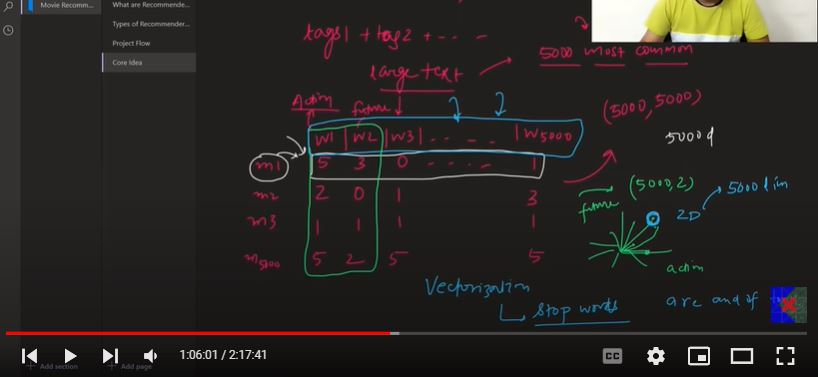

In [22]:
cv = CountVectorizer(max_features=5000,stop_words='english')


In [23]:
vector = cv.fit_transform(new['tags']).toarray()

In [24]:
vector.shape
#There are 4806 movies we are using as a row  and 5000 words we are using as a column

(4806, 5000)

In [25]:
similarity = cosine_similarity(vector)

In [26]:
new[new['title'] == 'The Lego Movie'].index[0]

744

In [27]:
def recommend(movie):
    index = new[new['title'] == movie].index[0]
    #heres the line below is very important we have a enumerate function to give index and the reverse give 
    # the sorting order in descending order and the third function sort by value score not by index 
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(new.iloc[i[0]].title)

In [28]:
recommend('Gandhi')

Gandhi, My Father
The Wind That Shakes the Barley
A Passage to India
Guiana 1838
Ramanujan


In [33]:
pickle.dump(new.to_dict(),open('movie_dict.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))